In [22]:
import cv2
import numpy as np
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
import tarfile
import seaborn as sns

In [44]:
GEN_DATA = False

### Image resizing and converting to grey scale

Below we resize each image to 256 X 256 and convert to grey scale for consistency, which becomes convenient when we use the CNNslater on. There is no need to run the below cell if we are using the data from getData.sh (see README)

In [40]:
if not GEN_DATA:
    print("GEN_DATA disabled")

else:

    images_train = []
    images_test = []


    for filename in os.listdir('data/training_set/cats'):
        if filename.endswith('.jpg'):
            image = cv2.imread(os.path.join('data/training_set/cats', filename))
            image = cv2.resize(image, (256, 256))
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            images_train.append(image)

    for filename in os.listdir('data/training_set/dogs'):
        if filename.endswith('.jpg'):
            image = cv2.imread(os.path.join('data/training_set/dogs', filename))
            image = cv2.resize(image, (256, 256))
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            images_train.append(image)

    for filename in os.listdir('data/test_set/cats'):
        if filename.endswith('.jpg'):
            image = cv2.imread(os.path.join('data/test_set/cats', filename))
            image = cv2.resize(image, (256, 256))
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            images_test.append(image)

    for filename in os.listdir('data/test_set/dogs'):
        if filename.endswith('.jpg'):
            image = cv2.imread(os.path.join('data/test_set/dogs', filename))
            image = cv2.resize(image, (256, 256))
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            images_test.append(image)

    random.shuffle(images_train)
    random.shuffle(images_test)

    for i in range(len(images_train)):
        cv2.imwrite(f'data/training_set_resized/training_image_resized_{i+1}.jpg', images_train[i])

    for i in range(len(images_test)):
        cv2.imwrite(f'data/test_set_resized/test_image_resized_{i+1}.jpg', images_test[i])
    



### Image Degradation Functions

Below are functions that degrade image quality via blurring, adding noise, or compression

In [54]:
def add_noise(image, noise_level=0.1, indx=0, set_type="test"):
    
    level = int((noise_level * 20) + 1) 

    noisy_image = image.copy()

    num_pixels = image.shape[0] * image.shape[1]
    num_noise_pixels = int(num_pixels * noise_level)
    
    for _ in range(num_noise_pixels):
        y = np.random.randint(0, image.shape[0])
        x = np.random.randint(0, image.shape[1])

        noise_color = np.random.randint(0, np.max(image))
        
        noisy_image[y, x] = noise_color
    
    cv2.imwrite(f'data/{set_type}_noise_{level}/{set_type}_image_noise_{indx+1}.jpg', noisy_image)
    
    return noisy_image

def add_gaussian_blur(image, kernel_size=(5, 5), indx=0, set_type="test"):
    
    level = round((kernel_size[0] - 1) / 4)
    
    blurred_image = cv2.GaussianBlur(image, kernel_size, 0)
    
    cv2.imwrite(f'data/{set_type}_blurred_{level}/{set_type}_image_blurred_{indx+1}.jpg', blurred_image)
    
    return cv2.GaussianBlur(image, kernel_size, 0)

def compress_image(image, quality=10, indx=0, set_type="test"):
    
    level = int(6 + (quality / -5))
    
    pil_image = Image.fromarray(image)
    compressed_image_path = f'data/{set_type}_compressed_{level}/{set_type}_image_compressed_{indx+1}.jpg'
    #compressed_image_path = f'data/test.jpg'
    pil_image.save(compressed_image_path, 'JPEG', quality=quality)
    compressed_image = cv2.imread(compressed_image_path)

    return compressed_image
 

### Generating Degraded Images

The below cell takes each of the non-degraded images and applies five levels of degradation for each of the three degradation types. There is no need to re-run this cell unless using images other than what is already given by genData.sh (see README)

In [67]:
if not GEN_DATA:
    print("GEN_DATA disabled")

else:
    print('Generating degraded images...')
    
    sorted_training = sorted([file for file in os.listdir('data/training_set_resized') if file.endswith('.jpg')], 
                         key = lambda x: int(x.split('_')[-1].split('.')[0]))
    sorted_test = sorted([file for file in os.listdir('data/test_set_resized') if file.endswith('.jpg')], 
                             key = lambda x: int(x.split('_')[-1].split('.')[0]))

    images_training_resized = [cv2.imread(os.path.join('data/training_set_resized', filename)) 
                               for filename in sorted_training]
    images_test_resized = [cv2.imread(os.path.join('data/test_set_resized', filename))
                               for filename in sorted_test]
    
    for indx, image in enumerate(images_training_resized):
        
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        add_gaussian_blur(image, (5, 5), indx, "training")
        add_gaussian_blur(image, (9, 9), indx, "training")
        add_gaussian_blur(image, (13, 13), indx, "training")
        add_gaussian_blur(image, (17, 17), indx, "training")
        add_gaussian_blur(image, (21, 21), indx, "training")

        add_noise(image, 0.01, indx, "training")
        add_noise(image, 0.05, indx, "training")
        add_noise(image, 0.10, indx, "training")
        add_noise(image, 0.15, indx, "training")
        add_noise(image, 0.20, indx, "training")

        compress_image(image, 25, indx, "training")
        compress_image(image, 20, indx, "training")
        compress_image(image, 15, indx, "training")
        compress_image(image, 10, indx, "training")
        compress_image(image, 5, indx, "training")

    for indx, image in enumerate(images_test_resized):
        
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        add_gaussian_blur(image, (5, 5), indx, "test")
        add_gaussian_blur(image, (9, 9), indx, "test")
        add_gaussian_blur(image, (13, 13), indx, "test")
        add_gaussian_blur(image, (17, 17), indx, "test")
        add_gaussian_blur(image, (21, 21), indx, "test")

        add_noise(image, 0.01, indx, "test")
        add_noise(image, 0.05, indx, "test")
        add_noise(image, 0.10, indx, "test")
        add_noise(image, 0.15, indx, "test")
        add_noise(image, 0.20, indx, "test")

        compress_image(image, 25, indx, "test")
        compress_image(image, 20, indx, "test")
        compress_image(image, 15, indx, "test")
        compress_image(image, 10, indx, "test")
        compress_image(image, 5, indx, "test")
        
    print('Done generating degraded images')

Generating degraded images...
Done generating degraded images


### Converting images to .npy files

Here we convert each directory of images into a numpy array and save it as a .npy file. This makes it easier to repeatedly load the images into numpy arrays and is more effecient than constantly reading a bunch of files into an array.

In [68]:
directories = [
    'data/training_set_resized',
    'data/training_blurred_1',
    'data/training_blurred_2',
    'data/training_blurred_3',
    'data/training_blurred_4',
    'data/training_blurred_5',
    'data/training_noise_1',
    'data/training_noise_2',
    'data/training_noise_3',
    'data/training_noise_4',
    'data/training_noise_5',
    'data/training_compressed_1',
    'data/training_compressed_2',
    'data/training_compressed_3',
    'data/training_compressed_4',
    'data/training_compressed_5',
    'data/test_set_resized',
    'data/test_blurred_1',
    'data/test_blurred_2',
    'data/test_blurred_3',
    'data/test_blurred_4',
    'data/test_blurred_5',
    'data/test_noise_1',
    'data/test_noise_2',
    'data/test_noise_3',
    'data/test_noise_4',
    'data/test_noise_5',
    'data/test_compressed_1',
    'data/test_compressed_2',
    'data/test_compressed_3',
    'data/test_compressed_4',
    'data/test_compressed_5'
]

for directory in directories:
    
    image_set_name = directory.replace('data/', '')
    
    if os.path.exists('{}/{}.npy'.format(directory, image_set_name)):
        
        print('{}.npy already exists'.format(image_set_name))
        
    else:
    
        print('Creating {}.npy'.format(image_set_name))

        image_data = []

        for filename in os.listdir(directory):

            if filename.endswith('.jpg'):

                img_path = os.path.join(directory, filename)
                img = Image.open(img_path)

                img_array = np.array(img)

                image_data.append(img_array)


        image_data = np.array(image_data)

        np.save('{}/{}'.format(directory, image_set_name), image_data)

training_set_resized.npy already exists
training_blurred_1.npy already exists
training_blurred_2.npy already exists
training_blurred_3.npy already exists
training_blurred_4.npy already exists
training_blurred_5.npy already exists
training_noise_1.npy already exists
training_noise_2.npy already exists
training_noise_3.npy already exists
training_noise_4.npy already exists
training_noise_5.npy already exists
training_compressed_1.npy already exists
training_compressed_2.npy already exists
training_compressed_3.npy already exists
training_compressed_4.npy already exists
training_compressed_5.npy already exists
test_set_resized.npy already exists
test_blurred_1.npy already exists
test_blurred_2.npy already exists
test_blurred_3.npy already exists
test_blurred_4.npy already exists
test_blurred_5.npy already exists
Creating test_noise_1.npy
Creating test_noise_2.npy
Creating test_noise_3.npy
Creating test_noise_4.npy
Creating test_noise_5.npy
test_compressed_1.npy already exists
test_compres

### Undegradaed image example

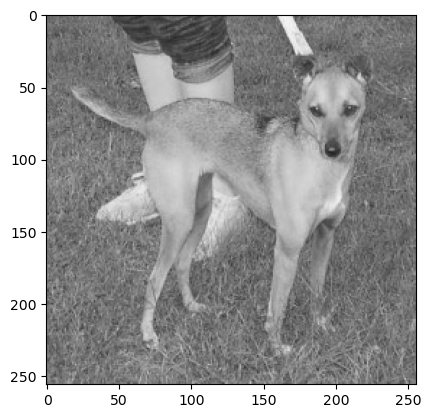

In [57]:
plt.imshow(cv2.imread('data/training_set_resized/training_image_resized_100.jpg'), cmap='gray')

### Five Levels of Blurring Example

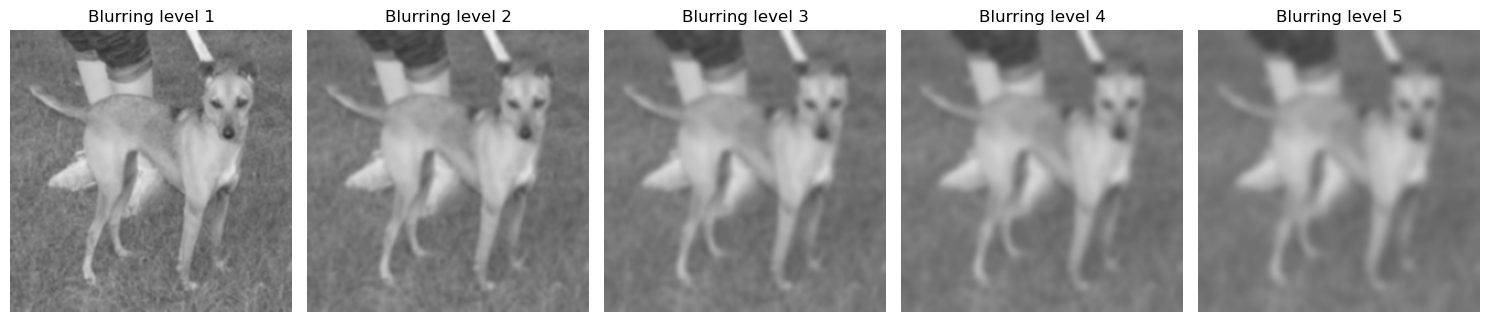

In [58]:
image_paths = ['data/training_blurred_1/training_image_blurred_100.jpg',
               'data/training_blurred_2/training_image_blurred_100.jpg',
               'data/training_blurred_3/training_image_blurred_100.jpg',
               'data/training_blurred_4/training_image_blurred_100.jpg',
               'data/training_blurred_5/training_image_blurred_100.jpg']

fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))

for ax, img_path in zip(axes, image_paths):

    image = cv2.imread(img_path)
    
    ax.imshow(image)
    ax.axis('off') 
    ax.set_title(f'Blurring level {img_path.split("_")[2][0]}')  

plt.tight_layout()
plt.show()

### Five Levels of Noise Example

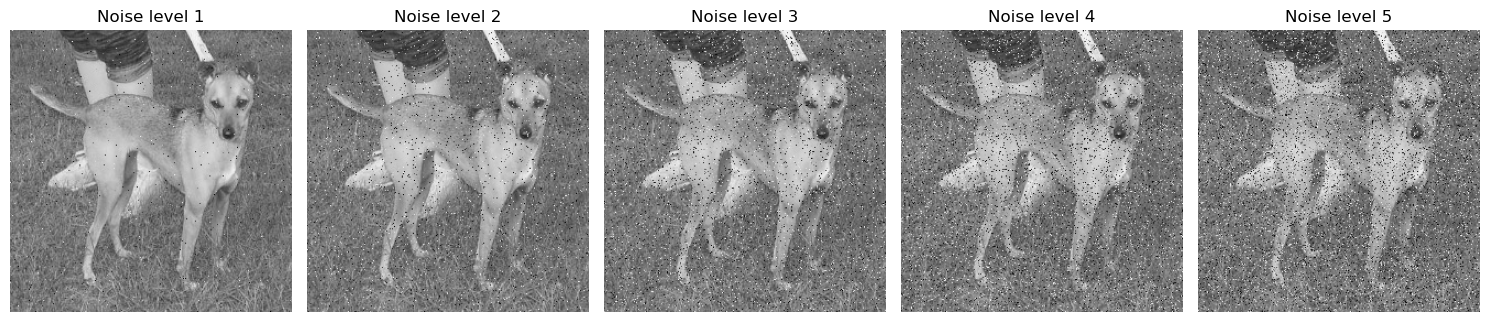

In [59]:
image_paths = ['data/training_noise_1/training_image_noise_100.jpg',
               'data/training_noise_2/training_image_noise_100.jpg',
               'data/training_noise_3/training_image_noise_100.jpg',
               'data/training_noise_4/training_image_noise_100.jpg',
               'data/training_noise_5/training_image_noise_100.jpg']

fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5)) 

for ax, img_path in zip(axes, image_paths):

    image = cv2.imread(img_path)
    
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f'Noise level {img_path.split("_")[2][0]}')

plt.tight_layout()
plt.show()

### Five Levels of Compression Example

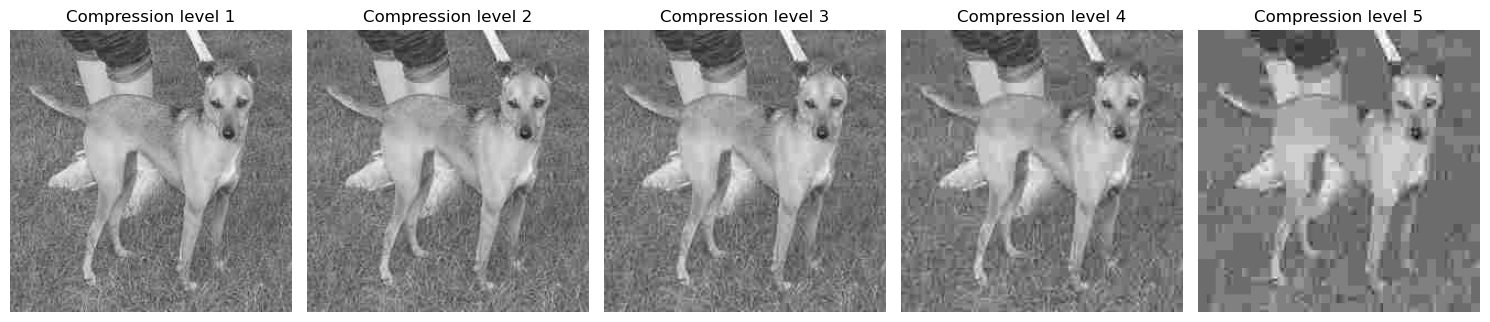

In [60]:
image_paths = ['data/training_compressed_1/training_image_compressed_100.jpg',
               'data/training_compressed_2/training_image_compressed_100.jpg',
               'data/training_compressed_3/training_image_compressed_100.jpg',
               'data/training_compressed_4/training_image_compressed_100.jpg',
               'data/training_compressed_5/training_image_compressed_100.jpg']

images = []

fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))

for ax, img_path in zip(axes, image_paths):
    image = cv2.imread(img_path)
    images.append(image)
    
    ax.imshow(image)
    ax.axis('off') 
    ax.set_title(f'Compression level {img_path.split("_")[2][0]}')

plt.tight_layout()
plt.show()

### Data set loader helper function

This function returns a training and test set of a partiular type of image. Types include, undegraded, blurred, noise, and compressed. In addition the degradation levels included in the set is controled by the degradation_levels parameter. This is an efficient way to load in datasets since it is using the .npy files created earlier. 

In [9]:
def get_data(degradation_type, degradation_levels=[], numImages=10000000, numImagesTest=10000000):

    if degradation_levels:
        deg = f'{degradation_type}_{degradation_levels[0]}'
    else:
        deg = f'{degradation_type}'
    
    train_images_np = np.load(f'data/training_{deg}/training_{deg}.npy')[0:numImages]

    test_images_np = np.load(f'data/test_{deg}/test_{deg}.npy')[0:numImagesTest]

    
    
    for i in degradation_levels[1:]:
        deg = f'{degradation_type}_{i}'
        train_images_np = np.concatenate((train_images_np, 
                                          np.load(f'data/training_{deg}/training_{deg}.npy')[0:numImages]), axis=0)

        test_images_np = np.concatenate((test_images_np,
                                          np.load(f'data/test_{deg}/test_{deg}.npy')[0:numImagesTest]), axis=0)
    
    return train_images_np, test_images_np

### Pytorch imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import TensorDataset, DataLoader

### Defining the CNN and some helper functions

In [3]:
class ConvNet(nn.Module):
    
    def __init__(self, num_classes=2):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) 
        self.pool = nn.MaxPool2d(6, 6)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x.view(-1, 1, 256, 256)))) 
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def np_to_torchLorder(images_np, labels_np, batchSize):
    images_torch = np.array(images_np)
    labels_torch = np.array(labels_np)

    images_tensor = torch.Tensor(images_torch).unsqueeze(1)
    labels_tensor = torch.Tensor(labels_torch).type(torch.LongTensor)

    DataSet = TensorDataset(images_tensor, labels_tensor)
    Loader = DataLoader(DataSet, batch_size=batchSize)
    return Loader

def trainCNN(images_np, labels_np, numImages=10000000, num_classes=2, epochs=20):

    convNet = ConvNet(num_classes)
    trainLoader = np_to_torchLorder(images_np[0:numImages], 
                                    labels_np[0:numImages], 256)
    trainLoaderTest = np_to_torchLorder(images_np[0:numImages], labels_np[0:numImages], 1)

    percentCorrectPerEpochTrain = []

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(convNet.parameters(), lr=0.001, momentum=0.9)
    loss = 1

    for epoch in range(epochs): 
        running_loss = 0.0
        for i, data in enumerate(trainLoader):

            inputs, labels = data
            
            optimizer.zero_grad()
   
            outputs = convNet(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
      
            if i % 255 == 0:  
                print(f'Epoch {epoch+1} loss: {running_loss / 256 :.7f}')
                loss = running_loss / 256
 
            running_loss = 0.0
        
        numCorrect = 0
        dataiter = iter(trainLoaderTest)
        for image, label in dataiter:
            yhat = convNet(image)
            _, predicted = torch.max(yhat, 1)
            if predicted == label: numCorrect += 1
        percentCorrectPerEpochTrain.append(100*(numCorrect/len(images_np[0:numImages])))
        
    print('Finished Training')

    return convNet, percentCorrectPerEpochTrain

def testCNN(convNet, images, labels):
    numCorrect = 0
    testLoader = np_to_torchLorder(images, labels, 1)
    dataiter = iter(testLoader)
    for image, label in dataiter:
        yhat = convNet(image)
        _, predicted = torch.max(yhat, 1)
        if predicted == label: numCorrect += 1
    return 100*(numCorrect/len(images))

### Blurring degradation detection test

Here we train the CNN to classifiy an image as degraded or undegraded using the level 1 blurred images as the degraded set. This test is to see if the CNN can tell the difference between the lowest level of blurring and an undegraded image.

In [55]:
normal_train, normal_test = get_data('set_resized')
blurr_train, blurr_test = get_data('blurred', [1])

images_train = np.concatenate((normal_train, blurr_train))
images_train_labels = np.concatenate((np.zeros(len(normal_train)), np.ones(len(blurr_train))), axis=0)

images_test = np.concatenate((normal_test, blurr_test))
images_test_labels = np.concatenate((np.zeros(len(normal_test)), np.ones(len(blurr_test))), axis=0)

indicies = np.random.permutation(len(images_train))

convNet, percentCorrectPerEpochTrain = trainCNN(images_train[indicies], images_train_labels[indicies], 4000)

Epoch 1 loss: 0.0091310
Epoch 2 loss: 0.0030313
Epoch 3 loss: 0.0026810
Epoch 4 loss: 0.0025166
Epoch 5 loss: 0.0024038
Epoch 6 loss: 0.0023146
Epoch 7 loss: 0.0021854
Epoch 8 loss: 0.0020672
Epoch 9 loss: 0.0019617
Epoch 10 loss: 0.0018836
Epoch 11 loss: 0.0018110
Epoch 12 loss: 0.0017384
Epoch 13 loss: 0.0016671
Epoch 14 loss: 0.0016066
Epoch 15 loss: 0.0015551
Epoch 16 loss: 0.0015107
Epoch 17 loss: 0.0014710
Epoch 18 loss: 0.0014318
Epoch 19 loss: 0.0013951
Epoch 20 loss: 0.0013632
Finished Training


### Testing blurred detection

Here we can clearly see that the above CNN is capable of dedecting the lowest level of blurring.

In [56]:
print(f'Accuracy on test set blurr-1 {testCNN(convNet, images_test, images_test_labels):.4f}%')

Accuracy on test set blurr-1 98.6653%


### Noise degradation detection test

Here we train the CNN to classifiy an image as degraded or undegraded using the noise level 1 images as the degraded set. This test is to see if the CNN can tell the difference between the lowest level of noise and an undegraded image.

In [71]:
normal_train, normal_test = get_data('set_resized')
noise_train, noise_test = get_data('noise', [1])

images_train = np.concatenate((normal_train, noise_train))
images_train_labels = np.concatenate((np.zeros(len(normal_train)), np.ones(len(noise_train))), axis=0)

images_test = np.concatenate((normal_test, noise_test))
images_test_labels = np.concatenate((np.zeros(len(normal_test)), np.ones(len(noise_test))), axis=0)

indicies = np.random.permutation(len(images_train))

convNet, percentCorrectPerEpochTrain = trainCNN(images_train[indicies], images_train_labels[indicies], 4000)

Epoch 1 loss: 0.0041693
Epoch 2 loss: 0.0026588
Epoch 3 loss: 0.0023142
Epoch 4 loss: 0.0019083
Epoch 5 loss: 0.0018511
Epoch 6 loss: 0.0012224
Epoch 7 loss: 0.0026730
Epoch 8 loss: 0.0022883
Epoch 9 loss: 0.0027026
Epoch 10 loss: 0.0020934
Epoch 11 loss: 0.0013720
Epoch 12 loss: 0.0007564
Epoch 13 loss: 0.0003275
Epoch 14 loss: 0.0000865
Epoch 15 loss: 0.0008523
Epoch 16 loss: 0.0002768
Epoch 17 loss: 0.0015338
Epoch 18 loss: 0.0005091
Epoch 19 loss: 0.0001624
Epoch 20 loss: 0.0000691
Finished Training


### Testing blurred detection

Here we can clearly see that the above CNN is capable of dedecting the lowest level of noise.

In [72]:
print(f'Accuracy on test set noise-1 {testCNN(convNet, images_test, images_test_labels):.4f}%')

Accuracy on test set noise-1 99.1349%


### Compression degradation detection test

Here we train the CNN to classifiy an image as degraded or undegraded using the level 5 compressed images as the degraded set. This test is to see if the CNN can tell the difference between the highest of compression and an undegraded image.

In [4]:
normal_train, normal_test = get_data('set_resized')
compressed_train, compressed_test = get_data('compressed', [5])

images_train = np.concatenate((normal_train, compressed_train))
images_train_labels = np.concatenate((np.zeros(len(normal_train)), np.ones(len(compressed_train))), axis=0)

images_test = np.concatenate((normal_test, compressed_test))
images_test_labels = np.concatenate((np.zeros(len(normal_test)), np.ones(len(compressed_test))), axis=0)

indicies = np.random.permutation(len(images_train))

print(images_train.shape, images_train_labels.shape)

convNet, percentCorrectPerEpochTrain = trainCNN(images_train[indicies], images_train_labels[indicies], 4000)

NameError: name 'get_data' is not defined

### Testing compression detection

Here we can clearly see that the above CNN is not really capable of dedecting the even the most extream level of compression.

In [82]:
print(f'Accuracy on test set compressed-1 {testCNN(convNet, images_test, images_test_labels):.4f}%')

Accuracy on test set compressed-1 0.5074%


### Degradation classification 

Here we train the CNN to classify the type of degradation as either undegraded, blurred, or noise. 

In [10]:
normal_train, normal_test = get_data('set_resized')
blurred_train, blurred_test = get_data('blurred', [1,2,3,4,5], numImages=2000, numImagesTest=2000)
noise_train, noise_test = get_data('noise', [1,2,3,4,5], numImages=2000, numImagesTest=2000)

images_train = np.concatenate((normal_train, blurred_train))
images_train_labels = np.concatenate((np.zeros(len(normal_train)), np.ones(len(blurred_train))), axis=0)

images_train = np.concatenate((images_train, noise_train))
images_train_labels = np.concatenate((images_train_labels, np.ones(len(noise_train))*2), axis=0)

images_test = np.concatenate((normal_test, blurred_test))
images_test_labels = np.concatenate((np.zeros(len(normal_test)), np.ones(len(blurred_test))), axis=0)

images_test = np.concatenate((images_test, noise_test))
images_test_labels = np.concatenate((images_test_labels, np.ones(len(noise_test))*2), axis=0)

indicies = np.random.permutation(len(images_train))

if os.path.exists('data/degradation_classifier.pth'):
    degradation_classifier = ConvNet(num_classes=3)
    degradation_classifier.load_state_dict(torch.load('data/degradation_classifier.pth'))
else:
    degradation_classifier, percentCorrectPerEpochTrain = trainCNN(images_train[indicies], images_train_labels[indicies], 
                                                                   num_classes=3, epochs=20)
    torch.save(degradation_classifier.state_dict(), "data/degradation_classifier.pth")

/tmp/ipykernel_8082/4130492641.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  degradation_classifier.load_state_dict(torch.load('data/degradation_classifier.pth'))


### Testing degradation type classification

In [11]:
print(f'Accuracy on test set blurr vs noise {testCNN(degradation_classifier, images_test, images_test_labels):.4f}%')

Accuracy on test set blurr vs noise 99.4415%


### Blurred level classification

Here we train a CNN to classify a blurred image as either lightly, moderately, or severely blurred.

In [15]:
blurred_train, blurred_test = get_data('blurred', [1,3,5], numImages=6000, numImagesTest=6000)

images_train_labels = np.ones(len(blurred_train))
images_test_labels = np.ones(len(blurred_test))

for i in range(0, 3):
    images_train_labels[i*len(blurred_train)//3:(i+1)*len(blurred_train)//3] = int(i)
    images_test_labels[i*len(blurred_test)//3:(i+1)*len(blurred_test)//3] = int(i)


indicies = np.random.permutation(len(blurred_train))

if os.path.exists('data/blurred_level_classifier.pth'):
    blurred_level_classifier = ConvNet(num_classes=3)
    blurred_level_classifier.load_state_dict(torch.load('data/blurred_level_classifier.pth'))
else:
    blurred_level_classifier, percentCorrectPerEpochTrain = trainCNN(blurred_train[indicies], images_train_labels[indicies], 
                                                    numImages=30000, num_classes=3, epochs=20)
    torch.save(blurred_level_classifier.state_dict(), "data/blurred_level_classifier.pth")

/tmp/ipykernel_8082/2548063948.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  blurred_level_classifier.load_state_dict(torch.load('data/blurred_level_classifier.pth'))

### Blurred level classification test

In [16]:
print(f'Accuracy on test set blurr-1/2/3 {testCNN(blurred_level_classifier, blurred_test, images_test_labels):.4f}%')

Accuracy on test set blurr-1/2/3 95.1063%


### Noise level classification

Here we train a CNN to classify the amount of noise in a noise degraded image as either light, moderate, or severe.

In [22]:
noise_train, noise_test = get_data('noise', [1,3,5], numImages=4000, numImagesTest=6000)

images_train_labels = np.ones(len(noise_train))
images_test_labels = np.ones(len(noise_test))

for i in range(0, 3):
    images_train_labels[i*len(noise_train)//3:(i+1)*len(noise_train)//3] = int(i)
    images_test_labels[i*len(noise_test)//3:(i+1)*len(noise_test)//3] = int(i)


indicies = np.random.permutation(len(noise_train))

if os.path.exists('data/noise_level_classifier.pth'):
    noise_level_classifier = ConvNet(num_classes=3)
    noise_level_classifier.load_state_dict(torch.load('data/noise_level_classifier.pth'))
else:
    noise_level_classifier, percentCorrectPerEpochTrain = trainCNN(noise_train[indicies], images_train_labels[indicies], 
                                                                   numImages=30000, num_classes=3, epochs=20)
    torch.save(noise_level_classifier.state_dict(), "data/noise_level_classifier.pth")

Epoch 1 loss: 0.0086730
Epoch 2 loss: 0.0025373
Epoch 3 loss: 0.0036132
Epoch 4 loss: 0.0012543
Epoch 5 loss: 0.0015338
Epoch 6 loss: 0.0007791
Epoch 7 loss: 0.0040601
Epoch 8 loss: 0.0037791
Epoch 9 loss: 0.0035946
Epoch 10 loss: 0.0035625
Epoch 11 loss: 0.0032458
Epoch 12 loss: 0.0033837
Epoch 13 loss: 0.0031139
Epoch 14 loss: 0.0038044
Epoch 15 loss: 0.0030155
Epoch 16 loss: 0.0022913
Epoch 17 loss: 0.0043742
Epoch 18 loss: 0.0028395
Epoch 19 loss: 0.0025772
Epoch 20 loss: 0.0022587
Finished Training


### Noise level classification test

In [23]:
print(f'Accuracy on test set noise-1/2/3 {testCNN(noise_level_classifier, noise_test, images_test_labels):.4f}%')

Accuracy on test set noise-1/2/3 89.3228%


### Creating Test Set With Undegraded, Blurred, and Noise 

Here we are creating a testing set consiting of the undegraded, blurred (light, moderate, and severe), and noise (light, moderate, and severe) images. 

In [10]:
normal_train, normal_test = get_data('set_resized')
blurred_train, blurred_test = get_data('blurred', [1,3,5])
noise_train, noise_test = get_data('noise', [1,3,5])

images_test = np.concatenate((normal_test, blurred_test))
images_test = np.concatenate((images_test, noise_test))

images_test_labels = np.concatenate((np.zeros(len(normal_test)), np.ones(len(blurred_test)//3)), axis=0)
images_test_labels = np.concatenate((images_test_labels, np.ones(len(blurred_test)//3)*2), axis=0)
images_test_labels = np.concatenate((images_test_labels, np.ones(len(blurred_test)//3)*3), axis=0)
images_test_labels = np.concatenate((images_test_labels, np.ones(len(noise_test)//3)*4), axis=0)
images_test_labels = np.concatenate((images_test_labels, np.ones(len(noise_test)//3)*5), axis=0)
images_test_labels = np.concatenate((images_test_labels, np.ones(len(noise_test)//3)*6), axis=0)

indicies = np.random.permutation(len(images_test))

images_test = images_test[indicies]
images_test_labels = images_test_labels[indicies]

degradation_classifier = ConvNet(num_classes=3)
blurred_level_classifier = ConvNet(num_classes=3)
noise_level_classifier = ConvNet(num_classes=3)

degradation_classifier.load_state_dict(torch.load('data/degradation_classifier.pth'))
blurred_level_classifier.load_state_dict(torch.load('data/blurred_level_classifier.pth'))
noise_level_classifier.load_state_dict(torch.load('data/noise_level_classifier.pth'))


deg_type_map = {
    0 : "undegraded",
    1 : "blurred",
    2 : "noise"
}

/tmp/ipykernel_8962/272336816.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  degradation_classifier.load_state_dict(torch.load('data/degradation_classifier.pth'))
/tmp

### Predicting Degradation Type and Severity Over the Entire Test Set

Here we combine our CNN that was trained to classify the type of degradation with the CNNs trained to classify the degree of degradation. The idea is to first classify the type of degradation (if there is any at all), and then determine the degree of degradation.

In [31]:
confusion_matrix = np.zeros((7,7))

wrongly_classified = {
    0 : [],
    1 : [],
    2 : [],
    3 : [],
    4 : [],
    5 : [],
    6 : []
}

numCorrect = 0
testLoader = np_to_torchLorder(images_test, images_test_labels, 1)
dataiter = iter(testLoader)

for image, label in dataiter:
    yhat = degradation_classifier(image)
    _, deg_type = torch.max(yhat, 1)
    
    deg_type = int(deg_type)
    
    if deg_type_map[deg_type] == "undegraded":
        if label == deg_type:
            numCorrect += 1
            confusion_matrix[label, deg_type] += 1
        else:
            wrongly_classified[deg_type].append(image)
    elif deg_type_map[deg_type] == "blurred":
        yhat = blurred_level_classifier(image)
        _, prediction = torch.max(yhat, 1)
        if label == (prediction + 1):
            numCorrect += 1
            confusion_matrix[label, (prediction + 1)] += 1
        else:
            confusion_matrix[(prediction + 1), label] += 1
            wrongly_classified[int(prediction) + 1].append(image)
    elif deg_type_map[deg_type] == "noise":
        yhat = noise_level_classifier(image)
        _, prediction = torch.max(yhat, 1)
        if label == (prediction + 4):
            numCorrect += 1 
            confusion_matrix[label, (prediction + 4)] += 1
        else:
            confusion_matrix[(prediction + 4), label] += 1
            wrongly_classified[int(prediction) + 4].append(image)

print(f'Overall Accuracy: {100*(numCorrect/len(images_test)):.4f}%')
    

Accuracy: 92.4652%


### Plotting Confusion Matrix

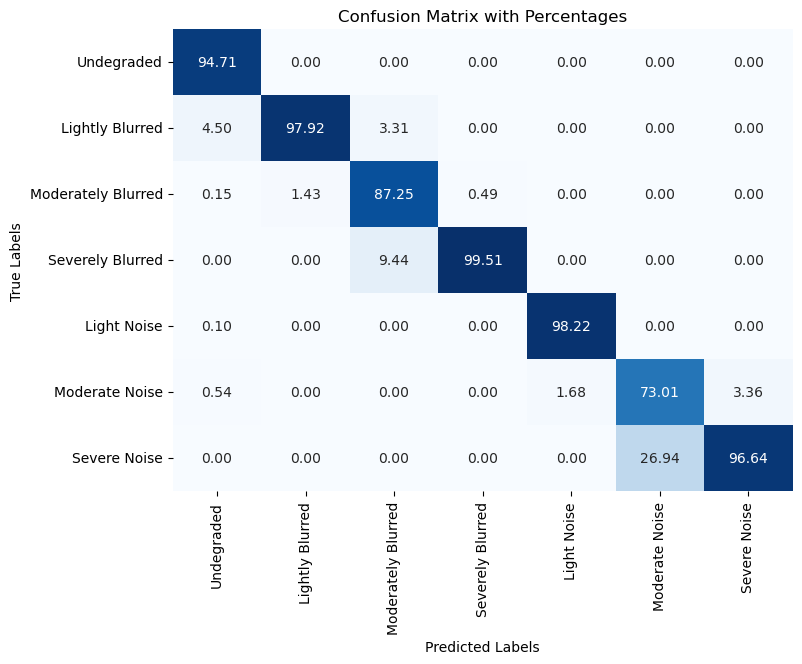

In [28]:
labels = ["Undegraded", "Lightly Blurred", "Moderately Blurred", "Severely Blurred", 
          "Light Noise", "Moderate Noise", "Severe Noise"]

mat = np.round(confusion_matrix * (100 / (len(blurred_test)/3)), 2)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(mat, annot=True, fmt=".2f", cmap="Blues", cbar=False,
                 xticklabels=labels, yticklabels=labels)
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix with Percentages")

plt.show()

### Examining Wrongly Classified Images

In [65]:
def plot_tensors(tensors, title, y=0.85):
    fig, axes = plt.subplots(1, len(tensors), figsize=(12, 4))

    for i, img in enumerate(tensors):
        if isinstance(img, torch.Tensor):
            img = img.squeeze().numpy()
        axes[i].imshow(img, cmap='gray')  
        axes[i].axis('off')

    plt.suptitle(title, ha='center', y=y)
    plt.show()

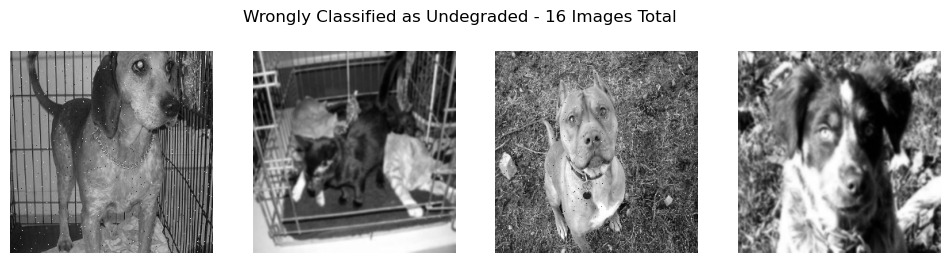

In [76]:
plot_tensors(wrongly_classified[0][:4], 
             f'Wrongly Classified as Undegraded - {len(wrongly_classified[0])} Images Total')

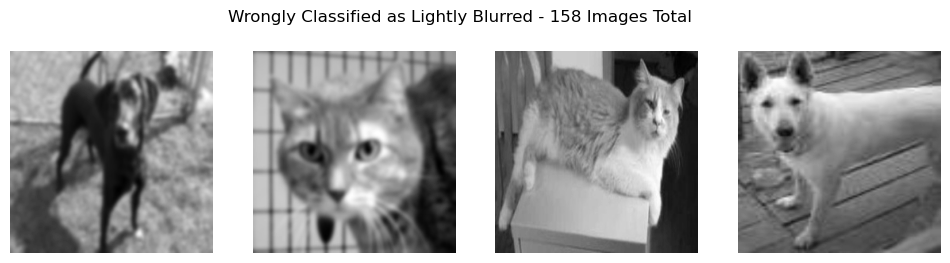

In [77]:
plot_tensors(wrongly_classified[1][:4], 
             f'Wrongly Classified as Lightly Blurred - {len(wrongly_classified[1])} Images Total')

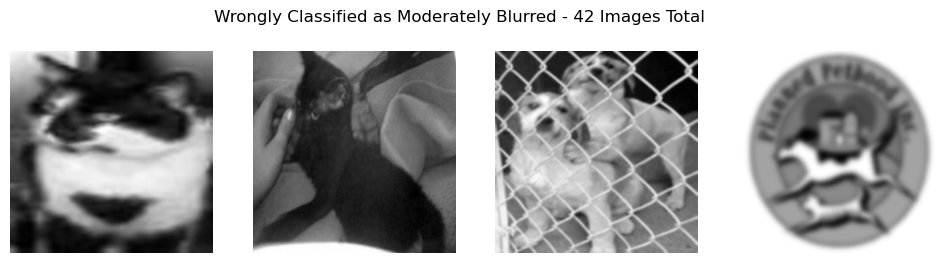

In [78]:
plot_tensors(wrongly_classified[2][:4], 
             f'Wrongly Classified as Moderately Blurred - {len(wrongly_classified[2])} Images Total')

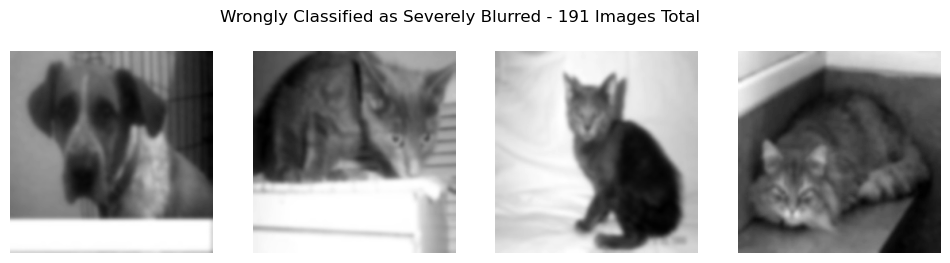

In [79]:
plot_tensors(wrongly_classified[3][:4], 
             f'Wrongly Classified as Severely Blurred - {len(wrongly_classified[3])} Images Total')

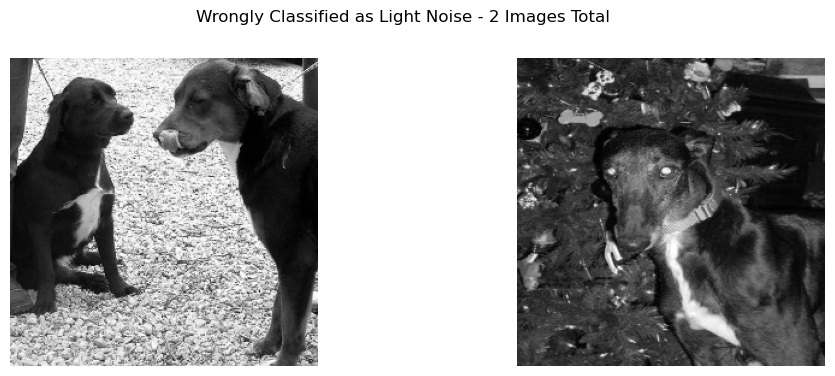

In [80]:
plot_tensors(wrongly_classified[4][:4], 
             f'Wrongly Classified as Light Noise - {len(wrongly_classified[4])} Images Total', y=1)

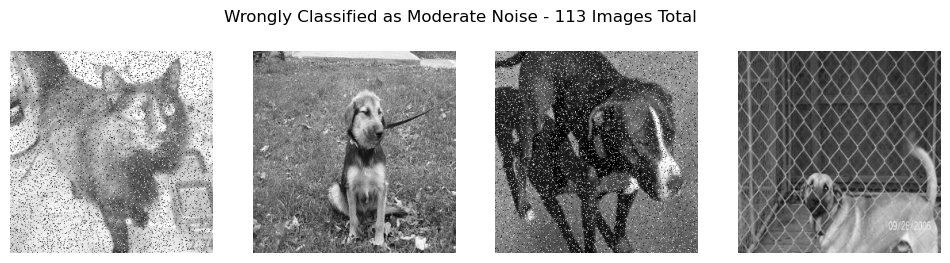

In [81]:
plot_tensors(wrongly_classified[5][:4], 
             f'Wrongly Classified as Moderate Noise - {len(wrongly_classified[5])} Images Total')

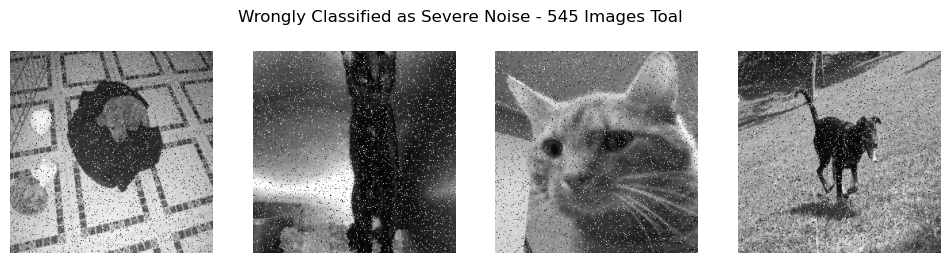

In [82]:
plot_tensors(wrongly_classified[6][:4], 
             f'Wrongly Classified as Severe Noise - {len(wrongly_classified[6])} Images Toal')